# Wikipedia Thanks Recipient Analysis 

[J. Nathan Matias](https://natematias.com), June 2024

Key documents:
* [pre-analysis plan: Receiving Thanks on Wikipedia](https://osf.io/c67rg/)
* [data format description](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit#heading=h.fxaguwxn13cj)
* Tresorit data in `Tresors/CivilServant/projects/wikipedia-integration/gratitude-study`

Decisions:
* With only 786 survey compliers, we are way under the sample needed to test our survey questions. So we will only report summary statistics for survey questions.
* Since we aren't testing survey-based hypotheses, we will reduce the number of comparisons that we adjust for.
* In this code, I don't adjust for language and sub-group in the meta-analysis. That's unnecessary because difference_in_means accounts for the randomization strategy. I misunderstood that at the time I pre-registered.

In [1]:
library(plyr)
library(AER)
library(tidyverse)
library(magrittr)
library(gmodels)
library(MASS)
library(estimatr)
library(ri2)
library(ggplot2)
library(ggpubr)   # contains ggarrange
library(png)      # to load logo
library(grid)

### TODO: Add Source Sans as a font for ggplot2
library(sysfonts) # to load source sans pro
# https://rdrr.io/github/kjhealy/sourcesans/src/R/sourcesans.r

## Set visual style
catpalette   <- c("#333333", "#ea5324", "#005073", "#7D868C", "#BDBBBB", "#F2F2F2","#F6F2EB")
chartpalette <- c("#ea5324", "#005073", "#7D868C", "#333333", "#F2F2F2","#BDBBBB", "#F6F2EB")

cat.theme <-  theme_bw() +
              theme(plot.title = element_text(size=13, face="bold", color=catpalette[3]),
                    axis.title.x =element_text(size=10, hjust = -0.01, color = catpalette[1]),
                    axis.title.y =element_text(size=10, color = catpalette[1]),
                    panel.background = element_rect(fill=catpalette[6]))

Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count

# Load Data

In [2]:
data.path = Sys.getenv('TRESORDIR', '~/Tresors')
tresor.path = 'CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thankee/post_experiment_analysis'
fname = 'grat-thankee-all-pre-post-treatment-vars.csv'
thank.fname = '2021-04-30-secondary-thanks.csv'
f.path = file.path(data.path, tresor.path, fname)
all.participants <- read.csv(f.path)
participant.thanks <- read.csv(file.path(data.path, tresor.path, thank.fname))

In [10]:
start.date = "2019-08-02"
end.date   = "2020-02-11"

end.caption.text = "Details at: citizensandtech.org/research/how-do-wikipedians-thank-each-other/


Citizens & Technology Lab - citizensandtech.org
© Creative Commons International Attribution 4.0"

lab.anewc <- "all newcomers"
lab.newc <- "newcomers"
lab.exp <- "experienced"

In [99]:
### Load the logo for the blog post
# cat.logo.filename <- "../../assets/CAT-Logo-Horizontal-social-media-preview-color.png"
# logo.img <- readPNG(cat.logo.filename)
# logo.pngob <- rasterGrob(logo.img)

## Print the number of partiicpants in the experiment, before
## any randomization blocks are removed for analysis
nrow(all.participants)

[1] 15558

### Convert columns to column names and formats from the experiment plan

In [100]:
all.participants$two.week.retention  %<>% as.logical
all.participants$complier  %<>% as.logical
all.participants$has.email  %<>% as.logical
all.participants$thanks.not.received.skipped %<>% as.logical
all.participants$thanks.not.received.not.seen  %<>% as.logical
all.participants$thanks.not.received.error  %<>% as.logical
all.participants$thanks.not.received.user.deleted  %<>% as.logical
all.participants$received.multiple.thanks  %<>% as.logical
all.participants$complier.app.any.reason  %<>% as.logical

all.participants$TREAT <- all.participants$randomization.arm
all.participants$block <- all.participants$randomization.block.id
all.participants$prev.experience <- all.participants$prev.experience.assignment
all.participants$newcomer <- all.participants$prev.experience=="bin_0"

all.participants$prev.experience.assignment.days <- 
    as.numeric(str_replace(all.participants$prev.experience, "bin_", ""))

### Remove blocks that include accounts that were deleted

In [101]:
blocks.to.omit.deleted <- subset(all.participants, thanks.not.received.user.deleted)$block

#### Remove Blocks that were Multiply Thanked

In [102]:
length(unique(subset(all.participants,received.multiple.thanks)$block))
blocks.to.omit.multiple.thanks <- unique(subset(all.participants,received.multiple.thanks)$block)

[1] 81

#### Remove blocks that were deleted at the time

In [103]:
length(unique(c(blocks.to.omit.multiple.thanks,blocks.to.omit.deleted)))

[1] 142

#### Count omitted participants

In [104]:
nrow(subset(all.participants, block %in% blocks.to.omit.deleted | block %in% blocks.to.omit.multiple.thanks))
nrow(all.participants)

[1] 284

[1] 15558

In [105]:
participants <- subset(all.participants, 
                       (block %in% blocks.to.omit.deleted)!=TRUE & 
                       (block %in% blocks.to.omit.multiple.thanks)!=TRUE
                      )
nrow(participants)

[1] 15274

### Create counts of accounts by language and newcomer
These counts are used in the table of participants.

In [109]:
aggregate(all.participants[c("TREAT")], by=list(newcomer=all.participants$newcomer, lang=all.participants$lang), FUN=length)

newcomer,lang,TREAT
<lgl>,<chr>,<int>
TRUE,ar,3072
TRUE,de,5434
FALSE,fa,2416
FALSE,pl,2996
TRUE,pl,1640


In [111]:
print(paste("Polish newcomer % thanked", prettyNum((nrow(subset(all.participants, newcomer=="TRUE" & lang=="pl" & number.thanks.received>0 & TREAT==TRUE)) / nrow(subset(all.participants, newcomer=="TRUE" & lang=="pl" & TREAT==TRUE)))*100, digits=2),"%"))
print(paste("German newcomer % thanked", prettyNum((nrow(subset(all.participants, newcomer=="TRUE" & lang=="de" & number.thanks.received>0 & TREAT==TRUE)) / nrow(subset(all.participants, newcomer=="TRUE" & lang=="de" & TREAT==TRUE)))*100, digits=2),"%"))
print(paste("Arabic newcomer % thanked", prettyNum((nrow(subset(all.participants, newcomer=="TRUE" & lang=="ar" & number.thanks.received>0 & TREAT==TRUE)) / nrow(subset(all.participants, newcomer=="TRUE" & lang=="ar" & TREAT==TRUE)))*100, digits=2),"%"))

print(paste("Newcomer % thanked", prettyNum((nrow(subset(all.participants, newcomer=="TRUE" & number.thanks.received>0 & TREAT==TRUE)) / nrow(subset(all.participants, newcomer=="TRUE" & TREAT==TRUE)))*100, digits=2),"%"))


print(paste("Polish experienced % thanked", prettyNum((nrow(subset(all.participants, newcomer=="FALSE" & lang=="pl" & number.thanks.received>0 & TREAT==TRUE)) / nrow(subset(all.participants, newcomer=="FALSE" & lang=="pl" & TREAT==TRUE)))*100, digits=2),"%"))
print(paste("Persian experienced % thanked", prettyNum((nrow(subset(all.participants, newcomer=="FALSE" & lang=="fa" & number.thanks.received>0 & TREAT==TRUE)) / nrow(subset(all.participants, newcomer=="FALSE" & lang=="fa" & TREAT==TRUE)))*100, digits=2),"%"))
print(paste("Experienced % thanked", prettyNum((nrow(subset(all.participants, newcomer=="FALSE" & number.thanks.received>0 & TREAT==TRUE)) / nrow(subset(all.participants, newcomer=="FALSE" & TREAT==TRUE)))*100, digits=2),"%"))


[1] "Polish newcomer % thanked 14 %"
[1] "German newcomer % thanked 49 %"
[1] "Arabic newcomer % thanked 13 %"
[1] "Newcomer % thanked 32 %"
[1] "Polish experienced % thanked 72 %"
[1] "Persian experienced % thanked 7.3 %"
[1] "Experienced % thanked 43 %"


In [112]:
print(paste("Polish newcomer two week retention rate", prettyNum(nrow(subset(all.participants, newcomer=="TRUE" & lang=="pl" & TREAT==FALSE & two.week.retention))/
                                                                 nrow(subset(all.participants, newcomer=="TRUE" & lang=="pl" & TREAT==FALSE))                                                                
                                                                )))

print(paste("German newcomer two week retention rate", prettyNum(nrow(subset(all.participants, newcomer=="TRUE" & lang=="de" & TREAT==FALSE & two.week.retention))/
                                                                 nrow(subset(all.participants, newcomer=="TRUE" & lang=="de" & TREAT==FALSE))                                                                
                                                                )))

print(paste("Arabic newcomer two week retention rate", prettyNum(nrow(subset(all.participants, newcomer=="TRUE" & lang=="ar" & TREAT==FALSE & two.week.retention))/
                                                                 nrow(subset(all.participants, newcomer=="TRUE" & lang=="ar" & TREAT==FALSE))                                                                
                                                                )))

print(paste("Polish experienced two week retention rate", prettyNum(nrow(subset(all.participants, newcomer=="FALSE" & lang=="pl" & TREAT==FALSE & two.week.retention))/
                                                                 nrow(subset(all.participants, newcomer=="FALSE" & lang=="pl" & TREAT==FALSE))                                                                
                                                                )))

print(paste("Persian experienced two week retention rate", prettyNum(nrow(subset(all.participants, newcomer=="FALSE" & lang=="fa" & TREAT==FALSE & two.week.retention))/
                                                                 nrow(subset(all.participants, newcomer=="FALSE" & lang=="fa" & TREAT==FALSE))                                                                
                                                                )))

[1] "Polish newcomer two week retention rate 0.1963415"
[1] "German newcomer two week retention rate 0.1818182"
[1] "Arabic newcomer two week retention rate 0.109375"
[1] "Polish experienced two week retention rate 0.441255"
[1] "Persian experienced two week retention rate 0.3071192"


In [113]:
nrow(subset(all.participants, newcomer=="TRUE" & lang=="ar" & number.thanks.received>0)) / nrow(subset(all.participants, newcomer=="TRUE" & lang=="ar"))

[1] 0.06477865

# Baseline Descriptive Information
Included for anyone who wants to review further details in the study, particularly balance in various variables, but commented out since they are not reported in the paper.

## Study Participants

In [115]:
# CrossTable(participants$lang, participants$TREAT, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

## Previous Experience by Language


In [24]:
# CrossTable(participants$prev.experience.assignment.days, 
#            participants$lang, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

In [25]:
# CrossTable(participants$lang, 
#            participants$newcomer, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

## Treatment by Previous Experience

In [119]:
# CrossTable(participants$prev.experience.assignment.days, participants$TREAT, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

## Received Thanks by Experience and Language

In [27]:
# CrossTable(subset(participants, TREAT==1)$newcomer, 
#            subset(participants, TREAT==1)$complier.app.any.reason,
#            prop.t=FALSE, prop.chisq=FALSE, prop.c=FALSE)

In [28]:
# CrossTable(paste(subset(participants, TREAT==1)$lang, 
#                  subset(participants, TREAT==1)$newcomer), 
#            subset(participants, TREAT==1)$complier.app.any.reason,
#            prop.t=FALSE, prop.chisq=FALSE, prop.c=FALSE)

## Survey Compliance

### Survey Compliance by Language

In [120]:
sum(participants$complier)/nrow(participants)

[1] 0.05021605

In [122]:
# CrossTable(participants$prev.experience.assignment.days, participants$complier, 
#            prop.c = FALSE, prop.r=TRUE, 
#            prop.t=FALSE, prop.chisq = FALSE)

# Analysis

## Create Study Sub-Samples

In [123]:
newcomers.df <- subset(participants, newcomer==TRUE)
experienced.df <- subset(participants, newcomer==FALSE)
newcomer.compliers.df <- subset(newcomers.df,complier==TRUE)

In [124]:
# CrossTable(newcomers.df$lang, newcomers.df$TREAT, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

In [125]:
# CrossTable(experienced.df$lang, experienced.df$TREAT, 
#            prop.c = FALSE, prop.r=FALSE, 
#            prop.t=FALSE, prop.chisq = FALSE)

In [128]:
# CrossTable(newcomers.df$TREAT, newcomers.df$complier, 
#            prop.c = FALSE, prop.r=TRUE, 
#            prop.t=FALSE, prop.chisq = FALSE)

# Per-Language Analysis Method

In [129]:
df.estimates <- function(df, lang="all", subgroup="all"){

    df.compliers <- subset(df, complier)

    thanks.model.formula <- "thanks.sent ~ TREAT"
    if(lang=="all"){
        thanks.model.formula <- paste(thanks.model.formula, " + lang")
    }
    
    if(subgroup=="all"){
        thanks.model.formula <- paste(thanks.model.formula, " + newcomer")
    }
    
        
    thanks.model         <- glm.nb(thanks.model.formula, data=df)
    m.thanks.sent        <- coef(summary(thanks.model))
    m.thanks.sent        <- data.frame(cbind(m.thanks.sent, confint(thanks.model)))
    names(m.thanks.sent)[4] <- "pvalue"
    names(m.thanks.sent)[5] <- "CI.Lower"
    names(m.thanks.sent)[6] <- "CI.Upper"
    m.thanks.sent$DF       <- thanks.model$df.residual
    m.thanks.sent$model    <- "thanks sent"
    m.thanks.sent$t.value  <- NA
    m.thanks.sent$n.size   <- nrow(df)
    m.thanks.sent$n.thanked.count <- nrow(subset(df, complier.app.any.reason))
    
    m.retention            <- data.frame(coef(summary(difference_in_means(two.week.retention ~ TREAT, blocks=block, ci=TRUE, data=df))))
    m.retention$model      <- "retention"
    m.retention$z.value    <- NA
    m.retention$n.size     <- nrow(df)
    m.retention$n.thanked.count <- nrow(subset(df, complier.app.any.reason))
    
    m.labor.hours          <- data.frame(coef(summary(difference_in_means(labor.hours.per.day.diff ~ TREAT, blocks=block, ci=TRUE, data=df))))
    m.labor.hours$model    <- "labor hours"
    m.labor.hours$z.value  <- NA
    m.labor.hours$n.size   <- nrow(df)
    m.labor.hours$n.thanked.count <- nrow(subset(df, complier.app.any.reason))

    m.manip.check          <- data.frame(coef(summary(difference_in_means(remembered.thanks<=3 ~ TREAT, ci=TRUE, data=df.compliers))))
    m.manip.check$model    <- "manipulation check"
    m.manip.check$z.value  <- NA
    m.manip.check$n.size   <- nrow(df.compliers)
    m.manip.check$n.thanked.count <-  nrow(subset(df.compliers, complier.app.any.reason))

    names(m.retention)[4]           <- "pvalue"
    names(m.manip.check)[4]         <- "pvalue"
    names(m.labor.hours)[4]         <- "pvalue"


    m.thanks.sent$estimator        <- "glm.nb"
    m.retention$estimator          <- "difference_in_means"
    m.labor.hours$estimator        <- "difference_in_means"
    m.manip.check$estimator        <- "difference_in_means"

    result.df <- rbind(m.thanks.sent, m.retention, 
                       m.labor.hours, m.manip.check)
    
    result.df <- result.df[str_detect(row.names(result.df), "TREAT"),]
    
    #result.df[row.names(result.df)!="(Intercept)",]
    
    result.df$lang     <- lang
    result.df$subgroup <- subgroup
    
    result.df
}

### Aggregate and Adjust Results for All Participants

In [130]:
all.results <- df.estimates(participants)
all.results <- subset(all.results, model!="labor hours")

all.newcomer.results <- df.estimates(subset(participants, newcomer), subgroup="newcomer")
all.results <- rbind(all.results, subset(all.newcomer.results, model=="labor hours"))

## Adjust for multiple comparisons
# adjustment needs to be done at the level of each
# dataframe, since the tests are different for 
# different subgroups and languages.
# When doing adjustment for multiple comparisons
# we omit the manipulation check, since it's not
# one of the confirmatory tests

## Note: store the original p values in a list so they can be
## used for later adjustments
all.results.pvalues <- all.results[all.results$model!="manipulation check",]$pvalue


all.results[all.results$model!="manipulation check",]$pvalue <- p.adjust(all.results[all.results$model!="manipulation check",]$pvalue, method="holm")

Waiting for profiling to be done...

Waiting for profiling to be done...



In [131]:
all.results[c("model","Estimate", "pvalue", "CI.Lower", "CI.Upper", "n.size", "estimator", "subgroup")]

,model,Estimate,pvalue,CI.Lower,CI.Upper,n.size,estimator,subgroup
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
TREAT,thanks sent,0.474498984,2.054607e-03,0.1895588964,0.76009838,15274,glm.nb,all
TREAT1,retention,0.021998167,9.329827e-04,0.0100450078,0.03395133,15274,difference_in_means,all
TREAT3,manipulation check,0.292051066,2.074219e-16,0.2238649972,0.36023713,767,difference_in_means,all
TREAT2,labor hours,0.002876707,1.150049e-01,-0.0007008952,0.00645431,9984,difference_in_means,newcomer


# Generate Sub-Group Analyses

In [132]:
ar.newcomer.results <- df.estimates(subset(participants, lang=="ar" & newcomer), lang="ar", subgroup="newcomer")
de.newcomer.results <- df.estimates(subset(participants, lang=="de" & newcomer), lang="de", subgroup="newcomer")
pl.newcomer.results <- df.estimates(subset(participants, lang=="pl" & newcomer), lang="pl", subgroup="newcomer")

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...



In [133]:
fa.experienced.results <- df.estimates(subset(participants, lang=="fa" & newcomer!=TRUE), lang="fa", subgroup="experienced")
fa.experienced.results <- subset(fa.experienced.results,model!="labor hours")

pl.experienced.results <- df.estimates(subset(participants, lang=="pl" & newcomer!=TRUE), lang="pl", subgroup="experienced")
pl.experienced.results <- subset(pl.experienced.results,model!="labor hours")

Waiting for profiling to be done...

Waiting for profiling to be done...



In [134]:
ar.newcomer.results[ar.newcomer.results$model!="manipulation check",]$pvalue <- 
        p.adjust(ar.newcomer.results[ar.newcomer.results$model!="manipulation check",]$pvalue, method="holm")

de.newcomer.results[de.newcomer.results$model!="manipulation check",]$pvalue <- 
        p.adjust(de.newcomer.results[de.newcomer.results$model!="manipulation check",]$pvalue, method="holm")

pl.newcomer.results[pl.newcomer.results$model!="manipulation check",]$pvalue <- 
        p.adjust(pl.newcomer.results[pl.newcomer.results$model!="manipulation check",]$pvalue, method="holm")

fa.experienced.results[fa.experienced.results$model!="manipulation check",]$pvalue <- 
        p.adjust(fa.experienced.results[fa.experienced.results$model!="manipulation check",]$pvalue, method="holm")

pl.experienced.results[pl.experienced.results$model!="manipulation check",]$pvalue <- 
        p.adjust(pl.experienced.results[pl.experienced.results$model!="manipulation check",]$pvalue, method="holm")

In [136]:
all.lang.results <- rbind(ar.newcomer.results, de.newcomer.results,
                          pl.newcomer.results, fa.experienced.results,
                          pl.experienced.results, all.results)

#all.lang.results

### Adjust Sub-Group Analyses for Multiple Comparisons

In [137]:
all.results[all.results$model!="manipulation check",]$pvalue <- p.adjust(all.results[all.results$model!="manipulation check",]$pvalue, method="holm")

# Plot Results

### Plot Effect on Labor Hours

In [138]:
subset(all.lang.results, lang=="all" & model == "labor hours")

,Estimate,Std..Error,z.value,pvalue,CI.Lower,CI.Upper,DF,model,t.value,n.size,n.thanked.count,estimator,lang,subgroup
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
TREAT23,0.002876707,0.001824898,NA,0.1150049,-0.0007008952,0.00645431,4991,labor hours,1.576366,9984,1572,difference_in_means,all,newcomer


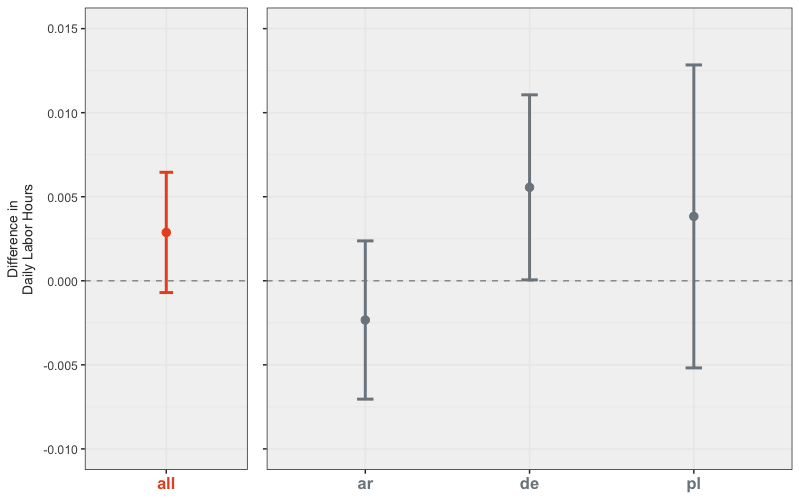

In [139]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

df1 <- subset(all.lang.results, model=="labor hours" & lang == "all" & subgroup=="newcomer")

df2 <- subset(all.lang.results, model=="labor hours" & subgroup=="newcomer" & lang!="all")


labor.hours.participants.count <- prettyNum(df1$n.size, big.mark=",")
labor.hours.participants.count.new.ar <- prettyNum(subset(df2, lang=="ar")$n.size, big.mark=',')
labor.hours.participants.count.new.de <- prettyNum(subset(df2, lang=="de")$n.size, big.mark=',')
labor.hours.participants.count.new.pl <-prettyNum(subset(df2, lang=="pl")$n.size, big.mark=',')
labor.hours.participants.assigned.perc <-round(df1$n.thanked.count/(df1$n.size/2)*100)
labor.hours.participants.assigned.total <-prettyNum(df1$n.size/2, big.mark=",")
labor.hours.participants.assigned.dimest <- prettyNum(df1$pvalue, digits=2)
labor.hours.ylab <- "Difference in\nDaily Labor Hours"


labor.hours.plot.caption <- str_interp("This study did not detect an effect of organized thanks on changes in the amount of time that 
newcomers contribute to Wikipedia on average.")


all.plot <- ggplot(df1, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=1, color=chartpalette[1], width=0.1) +
        geom_point(color=chartpalette[1], size=2.5) +
        ylab(labor.hours.ylab) +
        cat.theme + 
        theme(axis.title.x=element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[1])) +
        ylim(-0.01, 0.015)



lang.plot <- ggplot(df2, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=1, color=chartpalette[3], width=0.1) +
        geom_point(color=chartpalette[3], size=2.5) +
        cat.theme +
        theme(axis.text.y = element_blank(),
              axis.title  = element_blank(),
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[3])) +
        ylim(-0.01, 0.015)

labor.hours.plot <- ggarrange(all.plot, lang.plot, ncol=2, nrow=1, widths=c(1.5,3.2))

ggsave(file.path('../figs', 'labor.hours.plot.pdf'),
       width=6, height=2 , units='in', device="pdf",
       plot=labor.hours.plot)


## stored for compatibility with previous versions of ggplot
# labor.hours.plot <- annotate_figure(labor.hours.plot,
#                         bottom=text_grob(labor.hours.plot.caption, 
#                                          hjust=0, x=0, size=10, 
#                                          color=chartpalette[4])) +
#                     ggsave(file.path('../figs', 'labor.hours.plot.png'),
#                           width=6, height=3.375 , units='in')
labor.hours.plot

### Plot Effect on Two-Week Retention

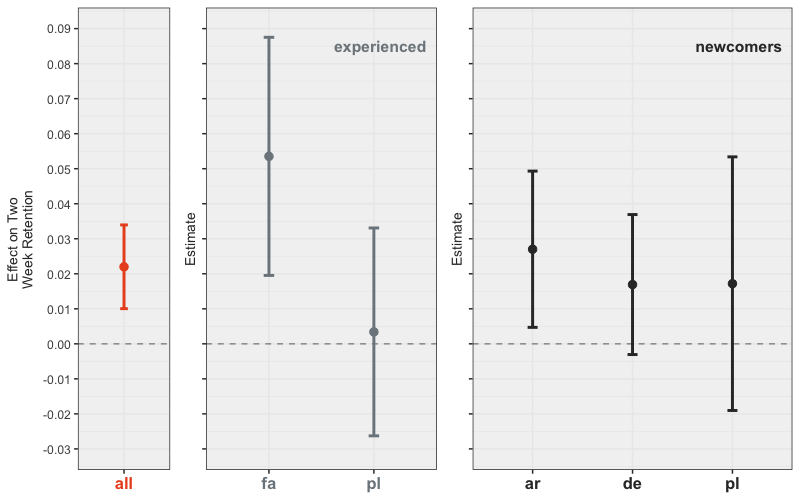

In [140]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

ymax = 0.09
ymin = -0.03

df1 <- subset(all.lang.results, model=="retention" & lang == "all")
df2 <- subset(all.lang.results, model=="retention" & lang!="all" & subgroup == "newcomer")
df3 <- subset(all.newcomer.results, model=="retention")
df4 <- subset(all.lang.results, model=="retention" & lang != "all" & subgroup == "experienced")


retention.plot.est <- prettyNum(df1$Estimate*100, digits=1, format="fg")
retention.plot.count.part <-prettyNum(df1$n.size, big.mark=",")
retention.plot.count.part.new.ar <- prettyNum(subset(df2, lang=="ar")$n.size, big.mark=',')
retention.plot.count.part.new.de <- prettyNum(subset(df2, lang=="de")$n.size, big.mark=',')
retention.plot.count.part.new.pl <- prettyNum(subset(df2, lang=="pl")$n.size, big.mark=',')
retention.plot.count.part.exp.fa <- prettyNum(subset(df4, lang=="fa")$n.size, big.mark=',')
retention.plot.count.part.exp.pl <-prettyNum(subset(df4, lang=="pl")$n.size, big.mark=',')
retention.plot.participants.assigned.perc <-round(df1$n.thanked.count/(df1$n.size/2)*100)
retention.plot.participants.assigned.total <-prettyNum(df1$n.size/2, big.mark=",")
retention.plot.participants.assigned.dimest <- prettyNum(df1$pvalue, digits=2)

retention.plot.ylab <- "Effect on Two\nWeek Retention"
retention.plot.caption <- str_interp(
    "Organized thanking increases two-week retention of Wikipedia contributors by ${retention.plot.est} percentage 
points on average among experienced and newcomer accounts")
 
all.plot <- ggplot(df1, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
            geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                          size=1, color=chartpalette[1], width=0.1) +
            geom_point(color=chartpalette[1], size=2.5) +
            ylab(retention.plot.ylab) +
            scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.01)) +
            cat.theme + 
            theme(axis.title.x=element_blank(),
                  axis.text.x = element_text(size=12, face="bold", color=chartpalette[1]))



lang.plot <- ggplot(df2, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=1, color=chartpalette[4], width=0.1) +
        geom_point(color=chartpalette[4], size=2.5) +
        annotate(geom="text", x=3.5,y=0.085, label=lab.newc, 
                 color=chartpalette[4], fontface=2, size=4, hjust=1) +
        scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.01)) + 
        cat.theme +
        theme(axis.text.y = element_blank(),
              axis.title  = element_blank(), 
              axis.title.x = element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[4]))



# all.newcomer.plot <- ggplot(df3, aes(lang, Estimate)) +
#         geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
#         geom_errorbar(aes(ymax=df3$CI.Upper, ymin=df3$CI.Lower), 
#                       size=1, color=chartpalette[4], width=0.1) +
#         geom_point(color=chartpalette[4]) +
#         scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.01)) + 
#         scale_x_discrete(labels =c(lab.anewc))  +
#         cat.theme + 
#         theme(axis.text.y = element_blank(),
#               axis.title=element_blank(),
#               axis.text.x = element_text(size=12, face="bold", color=chartpalette[4]))


experienced.plot <- ggplot(df4, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=1, color=chartpalette[3], width=0.1) +
        geom_point(color=chartpalette[3], size=2.5) +
        annotate(geom="text", x=2.5,y=0.085, label=lab.exp, 
                 color=chartpalette[3], fontface=2, size=4, hjust=1) +
        scale_y_continuous( limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.01)) + 
        cat.theme + 
        theme(axis.text.y = element_blank(),
              axis.title.x = element_blank(),
              axis.title=element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[3]))

retention.plot <- ggarrange(all.plot, experienced.plot, lang.plot, ncol=3, nrow=1, widths=c(2,3, 4))

ggsave(file.path('../figs', 'retention.plot.pdf'),
       width=6, height=2 , device="pdf", units='in',
       plot=retention.plot)

## stored for compatibility with previous versions of ggplot
# retention.plot <- annotate_figure(retention.plot,
#                         bottom=text_grob(retention.plot.caption, 
#                                          hjust=0, x=0, size=10, 
#                                          color=chartpalette[4]))+
#                     ggsave(file.path('../figs', 'retention.plot.png'),
#                           width=6, height=3.375 , units='in')
retention.plot

### Plot effect on rate of thanks

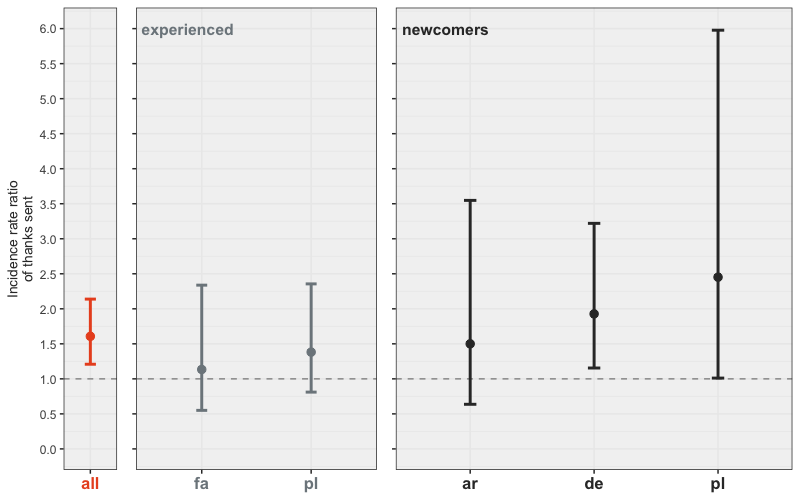

In [141]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

ymax = 6
ymin = 0
scale.by = 0.5

df1 <- subset(all.lang.results, model=="thanks sent" & lang == "all")
df2 <- subset(all.lang.results, model=="thanks sent" & lang!="all" & subgroup == "newcomer")
df3 <- subset(all.lang.results, model=="thanks sent" & lang != "all" & subgroup == "experienced")

thanks.sent.est <- prettyNum(exp(df1$Estimate), digits=2)
thanks.sent.ci.lower <- prettyNum(exp(df1$CI.Lower), digits=2, format="fg")
thanks.sent.ci.upper <- prettyNum(exp(df1$CI.Upper), digits=2, format="fg")
thanks.sent.part <- prettyNum(df1$n.size, big.mark=",")
thanks.sent.new.ar <- prettyNum(subset(df2, lang=="ar")$n.size, big.mark=',')
thanks.sent.new.de <- prettyNum(subset(df2, lang=="de")$n.size, big.mark=',')
thanks.sent.new.pl <- prettyNum(subset(df2, lang=="pl")$n.size, big.mark=',')
thanks.sent.exp.fa <- prettyNum(subset(df3, lang=="fa")$n.size, big.mark=',')
thanks.sent.exp.pl <- prettyNum(subset(df3, lang=="pl")$n.size, big.mark=',')
thanks.sent.assigned.perc <-round(df1$n.thanked.count/(df1$n.size/2)*100)
thanks.sent.assigned.total <-prettyNum(df1$n.size/2, big.mark=",")
thanks.sent.assigned.dimest <- prettyNum(df1$pvalue, digits=2)



thanks.sent.ylab <- "Incidence rate ratio\nof thanks sent"
thanks.sent.plot.caption <- str_interp("Organizing to thank Wikipedia volunteers caused them to thank others and increased the thanks they sent 
by ${thanks.sent.est} times on average")


all.plot <- ggplot(df1, aes(lang, exp(Estimate))) +
        geom_hline(yintercept = 1, linetype="dashed", color="#999999") +
            geom_errorbar(aes(ymax=exp(CI.Upper), ymin=exp(CI.Lower)), 
                          size=1, color=chartpalette[1], width=0.25) +
            geom_point(color=chartpalette[1], size=2.5) +
            ylab(thanks.sent.ylab) +
            scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=scale.by)) +
            cat.theme + 
            theme(axis.title.x=element_blank(),
                  axis.text.x = element_text(size=12, face="bold", color=chartpalette[1]))



newcomer.plot <- ggplot(df2, aes(lang, exp(Estimate))) +
        geom_hline(yintercept = 1, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=exp(CI.Upper), ymin=exp(CI.Lower)), 
                      size=1, color=chartpalette[4], width=0.1) +
        geom_point(color=chartpalette[4], size=2.5) +
        annotate(geom="text", x=0.45,y=6, label=lab.newc, 
                 color=chartpalette[4], fontface=2, size=4, hjust=0) +
        scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=scale.by)) + 
        cat.theme +
        theme(axis.text.y = element_blank(),
              axis.title  = element_blank(),
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[4]))



experienced.plot <- ggplot(df3, aes(lang, exp(Estimate))) +
        geom_hline(yintercept = 1, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=exp(CI.Upper), ymin=exp(CI.Lower)), 
                      size=1, color=chartpalette[3], width=0.1) +
        geom_point(color=chartpalette[3], size=2.5) +
        annotate(geom="text", x=0.45,y=6, label=lab.exp, 
                 color=chartpalette[3], fontface=2, size=4, hjust=0) +
        scale_y_continuous( limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=scale.by)) + 
        cat.theme + 
        theme(axis.text.y = element_blank(),
              axis.title=element_blank(),
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[3]))

thanks.sent.plot <- ggarrange(all.plot,  experienced.plot, newcomer.plot, ncol=3, nrow=1, widths=c(1.2,2.5, 4))

ggsave(file.path('../figs', 'thanks.sent.plot.pdf'),
       width=6, height=2, device="pdf", units='in',
       plot=thanks.sent.plot)

## stored for compatibility with previous versions of ggplot
# thanks.sent.plot <- annotate_figure(thanks.sent.plot,
#                         bottom=text_grob(thanks.sent.plot.caption, 
#                                          hjust=0, x=0, size=10, 
#                                          color=chartpalette[4]))+
#                     ggsave(file.path('../figs', 'thanks.sent.plot.png'),
#                           width=6, height=4 , units='in')
thanks.sent.plot

# Tables of All Results

In [143]:
all.lang.results

,Estimate,Std..Error,z.value,pvalue,CI.Lower,CI.Upper,DF,model,t.value,n.size,n.thanked.count,estimator,lang,subgroup
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
TREAT,0.405465108,0.435633350,0.9307485,6.621430e-01,-4.513355e-01,1.266331151,3034.00000,thanks sent,NA,3036,189,glm.nb,ar,newcomer
TREAT1,0.027009223,0.011373685,NA,5.305927e-02,4.699410e-03,0.049319036,1517.00000,retention,2.3747117,3036,189,difference_in_means,ar,newcomer
TREAT2,-0.002333275,0.002399823,NA,6.621430e-01,-7.040598e-03,0.002374048,1517.00000,labor hours,-0.9722694,3036,189,difference_in_means,ar,newcomer
TREAT3,0.200000000,0.210818511,NA,3.558411e-01,-2.441866e-01,0.644186588,17.30769,manipulation check,0.9486833,22,11,difference_in_means,ar,newcomer
TREAT4,0.656242624,0.260767478,2.5165815,3.554984e-02,1.438366e-01,1.169359242,5316.00000,thanks sent,NA,5318,1268,glm.nb,de,newcomer
TREAT11,0.016923656,0.010192528,NA,9.695231e-02,-3.062433e-03,0.036909744,2658.00000,retention,1.6603983,5318,1268,difference_in_means,de,newcomer
TREAT21,0.005559013,0.002806535,NA,9.544694e-02,5.580008e-05,0.011062226,2658.00000,labor hours,1.9807391,5318,1268,difference_in_means,de,newcomer
TREAT31,0.369369369,0.077406029,NA,4.445988e-06,2.163661e-01,0.522372655,143.50657,manipulation check,4.7718424,146,74,difference_in_means,de,newcomer
TREAT5,0.896746136,0.449821136,1.9935616,1.386000e-01,1.075717e-02,1.788012090,1628.00000,thanks sent,NA,1630,115,glm.nb,pl,newcomer


# Complier Average Causal Effect
We use two stage least squares regression to estimate the complier average causal effect.

In [144]:
## this method generates complier average treatment effect estimates
## for a given subgroup of the study. It assumes that rates of actual
## thanking by volunteers will vary by language and newcomer status

df.cace.estimates <- function(df, lang="all", subgroup="all"){

    
    treat.prob.formula <- "complier.app.any.reason ~ TREAT"
    if(lang=="all"){
        treat.prob.formula <- paste(treat.prob.formula, " + lang")
    }
    
    if(subgroup=="all"){
        treat.prob.formula <- paste(treat.prob.formula, " + newcomer")
    }
    
    treat.prob.m <- lm(treat.prob.formula, data=df)
    
    df$iv <- predict(treat.prob.m, df)

    df.compliers <- subset(df, complier)
    

    thanks.model         <- glm.nb(thanks.sent ~ iv, data=df)
    m.thanks.sent        <- coef(summary(thanks.model))
    m.thanks.sent        <- data.frame(cbind(m.thanks.sent, confint(thanks.model)))
    names(m.thanks.sent)[4] <- "pvalue"
    names(m.thanks.sent)[5] <- "CI.Lower"
    names(m.thanks.sent)[6] <- "CI.Upper"
    m.thanks.sent$DF       <- thanks.model$df.residual
    m.thanks.sent$model    <- "thanks sent"
    m.thanks.sent$t.value  <- NA
    m.thanks.sent$n.size   <- nrow(df)
    m.thanks.sent$n.thanked.count <- nrow(subset(df, complier.app.any.reason))
    
    retention.model        <- lm(two.week.retention ~ iv, data=df)
    m.retention            <- data.frame(coef(summary(retention.model)))
    m.retention            <- cbind(m.retention, confint(retention.model))
    names(m.retention)[4]  <- "pvalue"
    names(m.retention)[5]  <- "CI.Lower"
    names(m.retention)[6]  <- "CI.Upper"
    m.retention$DF         <- retention.model$df
    m.retention$model      <- "retention"
    m.retention$z.value    <- NA
    m.retention$n.size     <- nrow(df)
    m.retention$n.thanked.count <- nrow(subset(df, complier.app.any.reason))
    
    labor.hour.model       <- lm(labor.hours.per.day.diff ~ iv, data=df)
    m.labor.hours          <- data.frame(coef(summary(labor.hour.model)))
    m.labor.hours          <- cbind(m.labor.hours, confint(labor.hour.model))
    names(m.labor.hours)[4] <- "pvalue"
    names(m.labor.hours)[5] <- "CI.Lower"
    names(m.labor.hours)[6] <- "CI.Upper"
    m.labor.hours$DF       <- labor.hour.model$df    
    m.labor.hours$model    <- "labor hours"
    m.labor.hours$z.value  <- NA
    m.labor.hours$n.size   <- nrow(df)
    m.labor.hours$n.thanked.count <- nrow(subset(df, complier.app.any.reason))

    manip.check.model      <- lm(remembered.thanks<=3 ~ iv, data=df.compliers)
    m.manip.check          <- data.frame(coef(summary(manip.check.model)))
    m.manip.check          <- cbind(m.manip.check, confint(manip.check.model))
    names(m.manip.check)[4] <- "pvalue"
    names(m.manip.check)[5] <- "CI.Lower"
    names(m.manip.check)[6] <- "CI.Upper"
    m.manip.check$DF       <- manip.check.model$df    
    m.manip.check$model    <- "manipulation check"
    m.manip.check$z.value  <- NA
    m.manip.check$n.size   <- nrow(df.compliers)
    m.manip.check$n.thanked.count <-  nrow(subset(df.compliers, complier.app.any.reason))

    m.thanks.sent$estimator        <- "glm.nb"
    m.retention$estimator          <- "2sls"
    m.labor.hours$estimator        <- "2sls"
    m.manip.check$estimator        <- "2sls"

    result.df <- rbind(m.retention, m.labor.hours, m.thanks.sent,
                       m.manip.check)
    
    #result.df <- result.df[row.names(result.df)!="(Intercept)",]
    
    result.df$lang     <- lang
    result.df$subgroup <- subgroup
    
    result.df
}

#### Estimate CACE Results

In [145]:
ar.newcomer.cace.results <- df.cace.estimates(subset(participants, lang=="ar" & newcomer), lang="ar", subgroup="newcomer")
de.newcomer.cace.results <- df.cace.estimates(subset(participants, lang=="de" & newcomer), lang="de", subgroup="newcomer")
pl.newcomer.cace.results <- df.cace.estimates(subset(participants, lang=="pl" & newcomer), lang="pl", subgroup="newcomer")

fa.experienced.cace.results <- df.cace.estimates(subset(participants, lang=="fa" & newcomer!=TRUE), lang="fa", subgroup="experienced")
fa.experienced.cace.results <- subset(fa.experienced.cace.results,model!="labor hours")

pl.experienced.cace.results <- df.cace.estimates(subset(participants, lang=="pl" & newcomer!=TRUE), lang="pl", subgroup="experienced")
pl.experienced.cace.results <- subset(pl.experienced.cace.results,model!="labor hours")

all.newcomer.cace.df <- df.cace.estimates(subset(participants, newcomer), subgroup="newcomer")
all.experienced.cace.df <- df.cace.estimates(subset(participants, newcomer!=TRUE), subgroup="experienced")
all.experienced.cace.df <- subset(all.experienced.cace.df,model!="labor hours")

## create a dataframe of the main results table
all.cace.df <- df.cace.estimates(participants)

## create a dataframe of all results, for plotting charts
all.cace.models.df <- rbind(
    ar.newcomer.cace.results, 
    de.newcomer.cace.results, 
    pl.newcomer.cace.results,
    fa.experienced.cace.results,
    pl.experienced.cace.results,
    all.newcomer.cace.df,
    all.experienced.cace.df,
    all.cace.df
    )

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...



In [150]:
## In case readers want to view subgroups of CACE models

In [151]:
# subset(all.cace.models.df, model =="retention" & 
#                           str_detect(row.names(all.cace.models.df), "Intercept")!=TRUE)

In [152]:
# subset(all.cace.models.df, model =="labor hours" & 
#                           str_detect(row.names(all.cace.models.df), "Intercept")!=TRUE)

In [153]:
# subset(all.cace.models.df, model =="thanks sent" & 
#                           str_detect(row.names(all.cace.models.df), "Intercept")!=TRUE)

## Adjust p Values for CACE
Here, we adjust the CACE p values for all of the pre-registered analyses, as well as the CACE analyses.

In [154]:
## append all p values from the paper into a single list
## then adjust the p-values
## then return the first three, so they can be added to the adjustments

all.cace.iv.df <-  cbind(factor = rownames(all.cace.df), all.cace.df)
all.cace.iv.df <- subset(all.cace.iv.df, substring(all.cace.iv.df$factor, 0,2)=="iv")

all.cace.iv.df[all.cace.iv.df$model!="manipulation check",]$pvalue <- 
        p.adjust(c(all.cace.iv.df[all.cace.iv.df$model!="manipulation check",]$pvalue,all.results.pvalues))[1:3]
all.cace.iv.df

,factor,Estimate,Std..Error,t.value,pvalue,CI.Lower,CI.Upper,DF,model,z.value,n.size,n.thanked.count,estimator,lang,subgroup
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
iv,iv,0.197622356,0.016224987,12.180124,3.420956e-33,0.165819445,0.229425267,15272,retention,NA,15274,2702,2sls,all,all
iv1,iv1,0.001252543,0.004405865,0.284290,7.761920e-01,-0.007383478,0.009888565,15272,labor hours,NA,15274,2702,2sls,all,all
iv2,iv2,1.541253787,0.357115721,NA,7.949909e-05,0.896165950,2.190497607,15272,thanks sent,4.315839,15274,2702,glm.nb,all,all
iv3,iv3,0.687856191,0.091222590,7.540415,1.339146e-13,0.508777635,0.866934747,759,manipulation check,NA,767,369,2sls,all,all


## Plot CACE

In [155]:
dotsize = 1.5
errorsize = 1
all.cace.models.df <-  cbind(factor = rownames(all.cace.models.df), all.cace.models.df)

In [156]:
all.cace.models.iv.df <- subset(all.cace.models.df, substring(all.cace.models.df$factor, 0,2)=="iv")
all.cace.models.iv.df

,factor,Estimate,Std..Error,t.value,pvalue,CI.Lower,CI.Upper,DF,model,z.value,n.size,n.thanked.count,estimator,lang,subgroup
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
iv,iv,0.216931217,0.095210286,2.2784431,2.276941e-02,3.024801e-02,0.403614421,3034,retention,NA,3036,189,2sls,ar,newcomer
iv1,iv1,-0.018740272,0.019547635,-0.9586977,3.377875e-01,-5.706822e-02,0.019587678,3034,labor hours,NA,3036,189,2sls,ar,newcomer
iv2,iv2,3.256592773,3.498896428,NA,3.519836e-01,-3.625012e+00,10.170850197,3034,thanks sent,0.9307485,3036,189,glm.nb,ar,newcomer
iv3,iv3,1.606349206,1.693240737,0.9486833,3.553458e-01,-1.951018e+00,5.163715989,18,manipulation check,NA,22,11,2sls,ar,newcomer
iv4,iv4,0.035488959,0.022599886,1.5703158,1.164012e-01,-8.816091e-03,0.079794009,5316,retention,NA,5318,1268,2sls,de,newcomer
iv11,iv11,0.011657268,0.006062119,1.9229691,5.453729e-02,-2.269731e-04,0.023541508,5316,labor hours,NA,5318,1268,2sls,de,newcomer
iv21,iv21,1.376142852,0.546830224,NA,1.184995e-02,3.016257e-01,2.452150019,5316,thanks sent,2.5165815,5318,1268,glm.nb,de,newcomer
iv31,iv31,0.774568733,0.162251151,4.7738875,4.394985e-06,4.538672e-01,1.095270312,144,manipulation check,NA,146,74,2sls,de,newcomer
iv5,iv5,0.121739130,0.141443359,0.8606917,3.895346e-01,-1.556910e-01,0.399169277,1628,retention,NA,1630,115,2sls,pl,newcomer


### Plot IV Labor Hours

In [157]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

lh1 <- subset(all.cace.models.iv.df, model=="labor hours" & lang == "all" & subgroup=="newcomer")

lh2 <- subset(all.cace.models.iv.df, model=="labor hours" & subgroup=="newcomer" & lang!="all")


In [158]:
labor.hours.iv.participants.count <- prettyNum(lh1$n.size, big.mark=",")
labor.hours.iv.participants.count.new.ar <- prettyNum(subset(lh2, lang=="ar")$n.size, big.mark=',')
labor.hours.iv.participants.count.new.de <- prettyNum(subset(lh2, lang=="de")$n.size, big.mark=',')
labor.hours.iv.participants.count.new.pl <-prettyNum(subset(lh2, lang=="pl")$n.size, big.mark=',')
labor.hours.iv.participants.assigned.perc <-round(lh1$n.thanked.count/(lh1$n.size/2)*100)
labor.hours.iv.participants.assigned.total <-prettyNum(lh1$n.size/2, big.mark=",")
labor.hours.iv.participants.assigned.dimest <- prettyNum(lh1$pvalue, digits=2)
labor.hours.iv.ylab <- "Difference in\nDaily Labor Hours"


labor.hours.iv.plot.caption <- str_interp("This study did not detect an effect of organized thanks on changes in the amount of time that 
newcomers contribute to Wikipedia on average.")

In [159]:
lh1

,factor,Estimate,Std..Error,t.value,pvalue,CI.Lower,CI.Upper,DF,model,z.value,n.size,n.thanked.count,estimator,lang,subgroup
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
iv13,iv13,0.01015304,0.005223702,1.943649,0.05196588,-8.646709e-05,0.02039255,9982,labor hours,NA,9984,1572,2sls,all,newcomer


In [204]:
lh.all.plot <- ggplot(lh1, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=errorsize, color=chartpalette[1], width=0.1) +
        geom_point(color=chartpalette[1], size=dotsize) +
        ylab(labor.hours.iv.ylab) +
        cat.theme + 
        theme(axis.title.x=element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[1])) +
        ylim(-0.06, 0.1)

#lh.all.plot

In [164]:
lh2

,factor,Estimate,Std..Error,t.value,pvalue,CI.Lower,CI.Upper,DF,model,z.value,n.size,n.thanked.count,estimator,lang,subgroup
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
iv1,iv1,-0.01874027,0.019547635,-0.9586977,0.33778746,-0.0570682221,0.01958768,3034,labor hours,NA,3036,189,2sls,ar,newcomer
iv11,iv11,0.01165727,0.006062119,1.9229691,0.05453729,-0.0002269731,0.02354151,5316,labor hours,NA,5318,1268,2sls,de,newcomer
iv12,iv12,0.02713929,0.033722951,0.8047721,0.42106870,-0.0390056546,0.09328424,1628,labor hours,NA,1630,115,2sls,pl,newcomer


In [205]:
lh.lang.plot <- ggplot(lh2, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=errorsize, color=chartpalette[3], width=0.1) +
        geom_point(color=chartpalette[3], size=dotsize) +
        cat.theme +
        theme(axis.text.y = element_blank(),
              axis.title  = element_blank(), 
              axis.title.x=element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[3])) +
         ylab("") +
         xlab("") +
        ylim(-0.06, 0.1)

#lh.lang.plot

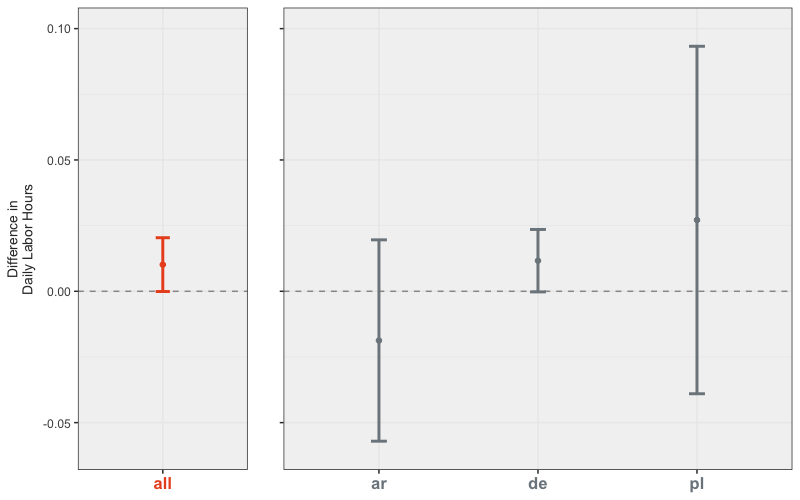

In [167]:
labor.hours.iv.plot <- ggarrange(lh.all.plot, lh.lang.plot, ncol=2, nrow=1, widths=c(1.5,3.2))

ggsave(file.path('../figs', 'labor.hours.iv.plot.pdf'),
       width=6, height=2 , units='in', device="pdf",
       plot=labor.hours.iv.plot)

labor.hours.iv.plot

## keep for compatibility with previous versions of ggplot2 
# labor.hours.iv.plot <- annotate_figure(labor.hours.iv.plot,
#                         bottom=text_grob(labor.hours.iv.plot.caption, 
#                                          hjust=0, x=0, size=10, 
#                                          color=chartpalette[4])) +
#                     ggsave(file.path('../figs', 'labor.hours.iv.plot.png'),
#                           width=6, height=3.375 , units='in')
#labor.hours.iv.plot

### Plot IV Two Week Retention

In [183]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

ymax = 0.5
ymin = -0.2

In [184]:
#all.cace.models.iv.df
twr1 <- subset(all.cace.models.iv.df, model=="retention" & lang == "all" & subgroup == "all")
twr2 <- subset(all.cace.models.iv.df, model=="retention" & lang!="all" & subgroup == "newcomer")
# twr3 <- subset(all.newcomer.results, model=="retention")
twr4 <- subset(all.lang.results, model=="retention" & lang != "all" & subgroup == "experienced")

In [185]:
retention.iv.plot.est <- prettyNum(twr1$Estimate*100, digits=1, format="fg")
retention.iv.plot.count.part <-prettyNum(twr1$n.size, big.mark=",")
retention.iv.plot.count.part.new.ar <- prettyNum(subset(twr2, lang=="ar")$n.size, big.mark=',')
retention.iv.plot.count.part.new.de <- prettyNum(subset(twr2, lang=="de")$n.size, big.mark=',')
retention.iv.plot.count.part.new.pl <- prettyNum(subset(twr2, lang=="pl")$n.size, big.mark=',')
retention.iv.plot.count.part.exp.fa <- prettyNum(subset(twr4, lang=="fa")$n.size, big.mark=',')
retention.iv.plot.count.part.exp.pl <-prettyNum(subset(twr4, lang=="pl")$n.size, big.mark=',')
retention.iv.plot.participants.assigned.perc <-round(twr1$n.thanked.count/(twr1$n.size/2)*100)
retention.iv.plot.participants.assigned.total <-prettyNum(twr1$n.size/2, big.mark=",")
retention.iv.plot.participants.assigned.dimest <- prettyNum(twr1$pvalue, digits=2)

retention.iv.plot.ylab <- "Effect on Two\nWeek Retention"
retention.iv.plot.caption <- str_interp(
    "Organized thanking increases two-week retention of Wikipedia contributors by ${retention.iv.plot.est} percentage 
points on average among experienced and newcomer accounts")

In [186]:
twr1

,factor,Estimate,Std..Error,t.value,pvalue,CI.Lower,CI.Upper,DF,model,z.value,n.size,n.thanked.count,estimator,lang,subgroup
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
iv10,iv10,0.1976224,0.01622499,12.18012,5.701594e-34,0.1658194,0.2294253,15272,retention,NA,15274,2702,2sls,all,all


In [187]:
twr.all.plot <- ggplot(twr1, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
            geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                          size=errorsize, color=chartpalette[1], width=0.2) +
            geom_point(color=chartpalette[1], size=dotsize) +
            ylab(retention.iv.plot.ylab) +
            scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.1)) +
            cat.theme + 
            theme(axis.title.x=element_blank(),
                  axis.text.x = element_text(size=12, face="bold", color=chartpalette[1]))

#twr.all.plot

twr.lang.plot <- ggplot(twr2, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=errorsize, color=chartpalette[4], width=0.1) +
        geom_point(color=chartpalette[4], size=dotsize) +
        annotate(geom="text", x=3.5,y=0.49, label=lab.newc, 
                 color=chartpalette[4], fontface=2, size=4, hjust=1) +
        scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.1)) + 
        cat.theme +
        theme(axis.text.y = element_blank(),
              axis.title.y = element_blank(),
              axis.title  = element_blank(),
              axis.title.x = element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[4]))
#twr.lang.plot

In [188]:
twr4

,Estimate,Std..Error,z.value,pvalue,CI.Lower,CI.Upper,DF,model,t.value,n.size,n.thanked.count,estimator,lang,subgroup
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
TREAT13,0.053525913,0.01732848,NA,0.004112216,0.01952773,0.08752410,1176,retention,3.0888986,2354,75,difference_in_means,fa,experienced
TREAT14,0.003405995,0.01512996,NA,0.821920504,-0.02627267,0.03308466,1467,retention,0.2251159,2936,1055,difference_in_means,pl,experienced


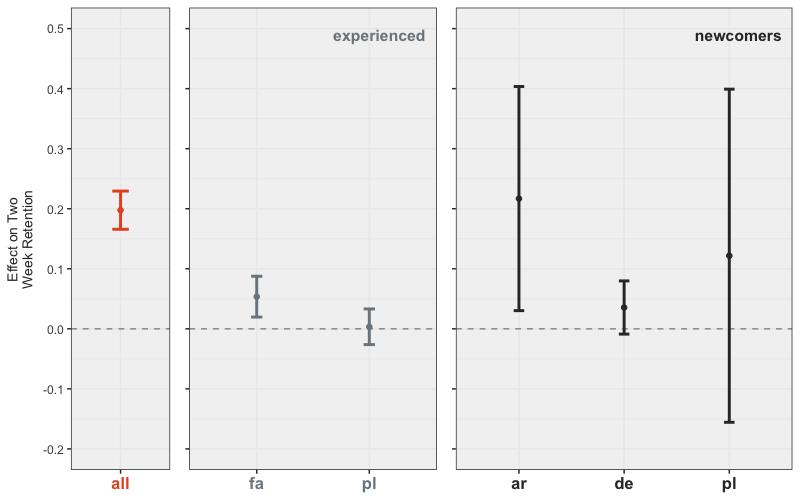

In [189]:
twr.experienced.plot <- ggplot(twr4, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=errorsize, color=chartpalette[3], width=0.1) +
        geom_point(color=chartpalette[3], size=dotsize) +
        annotate(geom="text", x=2.5,y=0.49, label=lab.exp, 
                 color=chartpalette[3], fontface=2, size=4, hjust=1) +
        scale_y_continuous( limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=0.1)) + 
        cat.theme + 
        theme(axis.text.y = element_blank(),
              axis.title=element_blank(),
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[3]))

#twr.experienced.plot
retention.iv.plot <- ggarrange(twr.all.plot, twr.experienced.plot, twr.lang.plot, ncol=3, nrow=1, widths=c(2,3, 4))

ggsave(file.path('../figs', 'retention.iv.plot.pdf'),
       width=6, height=2 , device="pdf", units='in',
       plot=retention.iv.plot)

## keep for compatibility with previous versions of ggplot2
# retention.iv.plot <- annotate_figure(retention.plot,
#                         bottom=text_grob(retention.iv.plot.caption, 
#                                          hjust=0, x=0, size=10, 
#                                          color=chartpalette[4]))+
#                     ggsave(file.path('../figs', 'retention.iv.plot.png'),
#                           width=6, height=3.375 , units='in')
retention.iv.plot

### Plot IV Effect on Rate of Thanks

In [190]:
rt1

,factor,Estimate,Std..Error,t.value,pvalue,CI.Lower,CI.Upper,DF,model,z.value,n.size,n.thanked.count,estimator,lang,subgroup
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
iv27,iv27,1.541254,0.3571157,NA,1.589982e-05,0.8961659,2.190498,15272,thanks sent,4.315839,15274,2702,glm.nb,all,all


In [191]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

ymax = 15
ymin = -10
scale.by = 5
rt1 <- subset(all.cace.models.iv.df, model=="thanks sent" & lang == "all" & subgroup == "all")
rt2 <- subset(all.cace.models.iv.df, model=="thanks sent" & lang!="all" & subgroup == "newcomer")
rt3 <- subset(all.cace.models.iv.df, model=="thanks sent" & lang != "all" & subgroup == "experienced")

thanks.sent.iv.est <- prettyNum(exp(rt1$Estimate), digits=2)
thanks.sent.iv.ci.lower <- prettyNum(exp(rt1$CI.Lower), digits=2, format="fg")
thanks.sent.iv.ci.upper <- prettyNum(exp(rt1$CI.Upper), digits=2, format="fg")
thanks.sent.iv.part <- prettyNum(rt1$n.size, big.mark=",")
thanks.sent.iv.new.ar <- prettyNum(subset(rt2, lang=="ar")$n.size, big.mark=',')
thanks.sent.iv.new.de <- prettyNum(subset(rt2, lang=="de")$n.size, big.mark=',')
thanks.sent.iv.new.pl <- prettyNum(subset(rt2, lang=="pl")$n.size, big.mark=',')
thanks.sent.iv.exp.fa <- prettyNum(subset(rt3, lang=="fa")$n.size, big.mark=',')
thanks.sent.iv.exp.pl <- prettyNum(subset(rt3, lang=="pl")$n.size, big.mark=',')
thanks.sent.iv.assigned.perc <-round(rt1$n.thanked.count/(rt1$n.size/2)*100)
thanks.sent.iv.assigned.total <-prettyNum(rt1$n.size/2, big.mark=",")
thanks.sent.iv.assigned.dimest <- prettyNum(rt1$pvalue, digits=2)


thanks.sent.iv.ylab <- "Negative binomial estimate\nof thanks sent"
thanks.sent.iv.plot.caption <- str_interp("Organizing to thank Wikipedia volunteers caused them to thank others and increased the thanks they sent 
by ${thanks.sent.iv.est} times on average")
#thanks.sent.iv.plot.caption
#rt3

In [192]:
rt.all.plot <- ggplot(rt1, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
            geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                          size=1, color=chartpalette[1], width=0.5) +
            geom_point(color=chartpalette[1], size=dotsize) +
            ylab(thanks.sent.iv.ylab) +
            scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=scale.by)) +
            cat.theme + 
            theme(axis.title.x=element_blank(),
                  axis.text.x = element_text(size=12, face="bold", color=chartpalette[1]))



rt.newcomer.plot <- ggplot(rt2, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=1, color=chartpalette[4], width=0.1) +
        geom_point(color=chartpalette[4], size=dotsize) +
        annotate(geom="text", x=2.6,y=ymax-0.25, label=lab.newc, 
                 color=chartpalette[4], fontface=2, size=4, hjust=0) +
        scale_y_continuous(limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=scale.by)) + 
        cat.theme +
        theme(axis.text.y = element_blank(),
              axis.title  = element_blank(), 
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[4]))


rt.experienced.plot <- ggplot(rt3, aes(lang, Estimate)) +
        geom_hline(yintercept = 0, linetype="dashed", color="#999999") +
        geom_errorbar(aes(ymax=CI.Upper, ymin=CI.Lower), 
                      size=1, color=chartpalette[3], width=0.1) +
        geom_point(color=chartpalette[3], size=dotsize) +
        annotate(geom="text", x=1.4,y=ymax-0.25, label=lab.exp, 
                 color=chartpalette[3], fontface=2, size=4, hjust=0) +
        scale_y_continuous( limits=c(ymin, ymax), breaks=seq(ymin, ymax, by=scale.by)) + 
        cat.theme + 
        theme(axis.text.y = element_blank(),
              axis.title=element_blank(),
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(size=12, face="bold", color=chartpalette[3]))

# rt.newcomer.plot
# rt.all.plot
#rt.experienced.plot

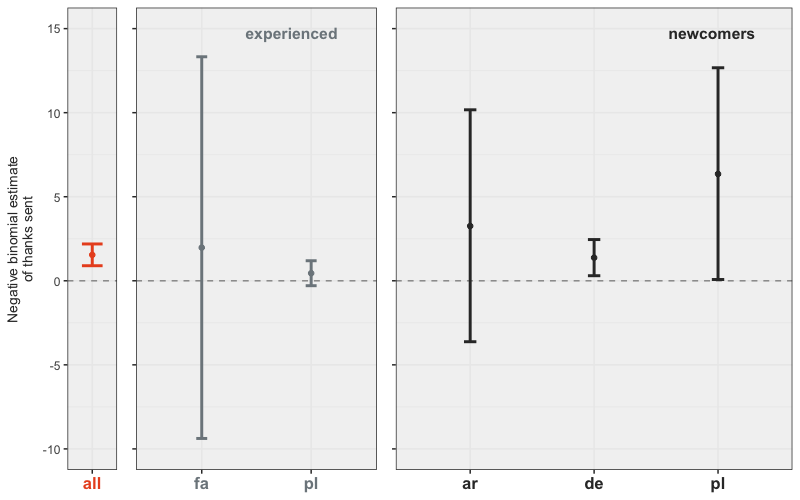

In [193]:
thanks.sent.iv.plot <- ggarrange(rt.all.plot,  rt.experienced.plot, rt.newcomer.plot, ncol=3, nrow=1, widths=c(1.2,2.5, 4))

ggsave(file.path('../figs', 'thanks.sent.iv.plot.pdf'),
    width=6, height=2, device="pdf", units='in',
    plot = thanks.sent.iv.plot)

# thanks.sent.iv.plot <- annotate_figure(thanks.sent.iv.plot,
#                         bottom=text_grob(thanks.sent.iv.plot.caption, 
#                                          hjust=0, x=0, size=10, 
#                                          color=chartpalette[4]))+
#                     ggsave(file.path('../figs', 'thanks.sent.iv.plot.png'),
#                           width=6, height=4 , units='in')
thanks.sent.iv.plot

# Analyze Participant Thanks

In [194]:
colnames(participant.thanks)

[1] "condition"                 "identifiable.thanks.sent" 
[3] "reciprocal.thanks.sent"    "nonreciprocal.thanks.sent"
[5] "lang"                      "any.reciprocal.thanks"    
[7] "any.nonreciprocal.thanks"

In [195]:
print(paste("according to the thanks dataset, ", nrow(subset(participant.thanks, identifiable.thanks.sent>0 & condition=="1")), "treatment group accounts sent thanks"))

print(paste("according to the earlier participant dataset, ", nrow(subset(participants, thanks.sent>0 & TREAT==1)), "treatment group accounts sent thanks"))

[1] "according to the thanks dataset,  266 treatment group accounts sent thanks"
[1] "according to the earlier participant dataset,  261 treatment group accounts sent thanks"


In [196]:
print(paste("according to the thanks dataset", sum(subset(participant.thanks, condition=='1')$identifiable.thanks.sent), "thanks were sent by treatment group accounts"))

print(paste("according to the participant dataset", sum(subset(participants, TREAT==1)$thanks.sent), "thanks were sent by treatment group accounts"))

[1] "according to the thanks dataset 1505 thanks were sent by treatment group accounts"
[1] "according to the participant dataset 1418 thanks were sent by treatment group accounts"


In [197]:
colnames(participant.thanks)

[1] "condition"                 "identifiable.thanks.sent" 
[3] "reciprocal.thanks.sent"    "nonreciprocal.thanks.sent"
[5] "lang"                      "any.reciprocal.thanks"    
[7] "any.nonreciprocal.thanks"

In [198]:
#participant.thanks
participant.thanks$any.reciprocal.thanks <- as.integer(participant.thanks$reciprocal.thanks.sent>0)
participant.thanks$any.nonreciprocal.thanks <- as.integer(participant.thanks$nonreciprocal.thanks.sent>0)

In [199]:
treat.reciprocal.thanks.df <- aggregate( . ~ lang, 
                                        data=participant.thanks[c('reciprocal.thanks.sent', 
                                                                  'nonreciprocal.thanks.sent', 
                                                                  'any.reciprocal.thanks',  
                                                                  'any.nonreciprocal.thanks', 
                                                                  'lang')], 
                                        FUN=sum)
treat.reciprocal.thanks.df

lang,reciprocal.thanks.sent,nonreciprocal.thanks.sent,any.reciprocal.thanks,any.nonreciprocal.thanks
<chr>,<int>,<int>,<int>,<int>
ar,0,91,0,36
de,1,404,1,130
fa,2,748,2,105
pl,3,1303,3,216


In [201]:
## percentage of thanks sent to people who did not thank them
prettyNum(sum(treat.reciprocal.thanks.df$nonreciprocal.thanks.sent)/ (sum(treat.reciprocal.thanks.df$nonreciprocal.thanks.sent) + sum(treat.reciprocal.thanks.df$reciprocal.thanks.sent))*100, digits=3)

[1] "99.8"

# Save Data for LaTeX file

In [202]:
dfs<-Filter(function(x) is.data.frame(get(x)) , ls())
save(list=dfs, file="paper-data.RData", version = 2) # overleaf uses R 3.4 which requires version 2 of Rdata I believe

In [203]:
colnames(participants)

[1] "private.anonymous.id"             "randomization.block.id"          
 [3] "labor.hours.per.day.diff"         "two.week.retention"              
 [5] "thanks.sent"                      "thanks.sent.pre.treatment"       
 [7] "wikipedians.value.contributions"  "community.friendly"              
 [9] "complier"                         "lang"                            
[11] "prev.experience.assignment"       "prev.experience.treatment"       
[13] "year"                             "has.email"                       
[15] "remembered.thanks"                "overall.exp"                     
[17] "social.value.1"                   "social.value.3"                  
[19] "social.value.4"                   "social.warmth.2"                 
[21] "social.warmth.3"                  "randomization.arm"               
[23] "number.thanks.received"           "number.skips.received"           
[25] "thanks.not.received.skipped"      "thanks.not.received.not.seen"    
[27] "thanks.not.received.error"        "thanks.not.received.user.deleted"
[29] "received.multiple.thanks"         "complier.app.any.reason"         
[31] "TREAT"                            "block"                           
[33] "prev.experience"                  "newcomer"                        
[35] "prev.experience.assignment.days"